Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv.

Данный датасет представляет собой совокупность твитов самого разного плана и тематики, но некоторые из них написаны с целью рассказать о реальном стихийном бедствии. Соревнование, предлагаемое каглом для этого датасета - придумать такую модель, которая бы могла предсказывать с наивысшей точностью, какие сообщения содержат в себе инофрмацию о реальной катастрофе, а какие нет.

Датасет содержит следующие колонки:


1. id - уникальный идентификатор для каждого твита
2. text - сообщение, содержащееся в твите
3. location - место, с которого твит был отправлен (может быть пустым)
4. keyword - ключевое слово твита, может быть пустым
5. target - целевая переменная, которая содержит информацию о том, содержало ли сообщение информацию о катастрофе или нет. Данный столбец есть только в файле train.csv, на котором мы будем обучать нашу модель.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = pd.read_csv('/content/sample_data/train.csv')
train #Формируем датафрейм, с которым будем работать в дальнейшем

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


1) Выведем информацию о пропусках в данных на экран. Если будут присутствовать пропуски, то мы заполним их пустой строкой

In [ ]:
train.isna().any() #Проверка на наличие каких-либо пропусков в данных. Пропуски есть в keyword и location.

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [ ]:
train.fillna('', inplace=True) #Заменяем все значения NaN на пустую строку.
train.isna().any().any() #Проверка на наличие пропусков. Значение False в результате, говорит о том, что пропусков больше нет.

False

In [ ]:
train.head(5) # Посмотрев на таблицу выше заметим, что значений NaN действительно нет.

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


2) Следующим шагом, хотелось бы оценить, какая точность предсказания модели является адекватной. Для этого необходимо посмотреть на распределение классов в выборке. Логично потребовать, чтобы модель имела точность более высокую, чем доля самого частого класса в выборке, в противном случае, даже "глупая" константная модель будет показывать лучшие результаты, чем наша "умная" обученная модель.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Class distribution')]

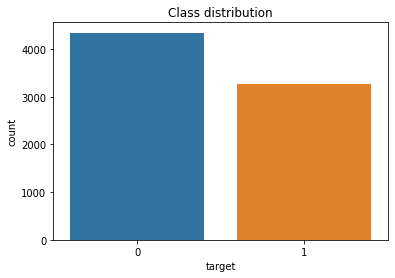

In [ ]:
sns.countplot(train['target']).set(title='Class distribution') #Выведем график с распределением классов.

In [ ]:
value_count = train['target'].value_counts() #Количество положительных и отрицательных классов в нашей выборке.
value_count

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
value_count[0]/(value_count[0]+value_count[1]) #Посчитали долю самого частого класса в выборке.

0.5703402075397347

Как видим, сообщения не содержащие информацию о стихийном бедствии занимают 57% выборки, следовательно точность разумной модели предсказаний должна быть выше 57%.

Теперь посмотрим колонку keyword и попробуем найти 10 наиболее часто встречающихся значений. Построим от них ступенчатую диаграмму распределения классов в зависимости от значения keyword.


In [ ]:
mod_keywords = train['keyword'].value_counts()[1:11].index.tolist() #Берем с 1, т.к. самый популярный keyword = '', формируем список ключей.
mod_train = train.loc[train['keyword'].isin(mod_keywords)] #Формируюм датафрейм из наблюдений в которых keyword находится в списке популярных.
mod_train['keyword'].value_counts() #Выведем частоту встречаемости самых частых ключевых слов в выборке.

fatalities     45
armageddon     42
deluge         42
body%20bags    41
damage         41
harm           41
sinking        41
evacuate       40
fear           40
outbreak       40
Name: keyword, dtype: int64

[Text(0.5, 1.0, 'Class distribution depending on the value of the keyword')]

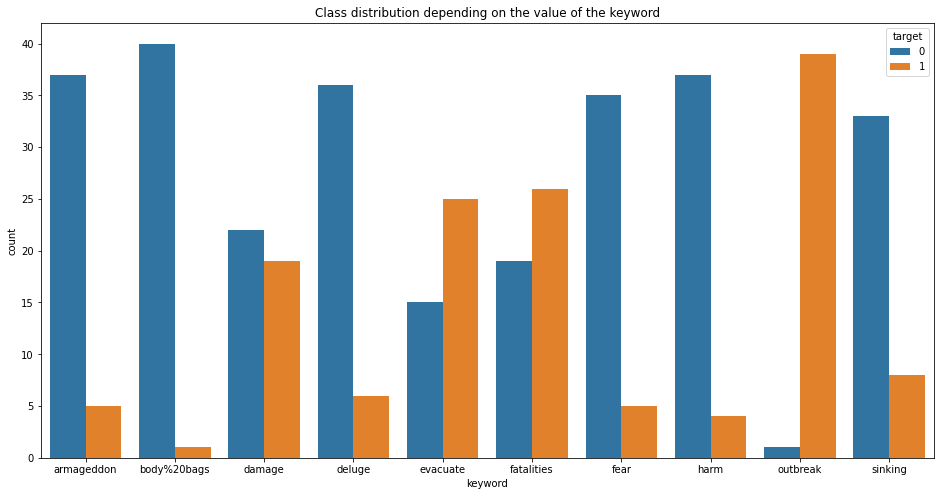

In [ ]:
plt.figure(figsize=(16,8))
sns.countplot(data=mod_train, x='keyword', hue='target').set(title='Class distribution depending on the value of the keyword')

Из таблицы видно, что в основном самые популярные ключевые слова, даже такие как armagedon, deluge, harm, sinking не указывают нам на наличие катастрофы. Однако есть и хорошие ключевые слова, которые могут рассматриваться как намек на то, что в сообщении будет содержаться информация о катастрофе. Это такие слова как evacuate, fatalities, outbreak.

3) Подготовим наши данные для дальнейшей работы

In [ ]:
train.drop('id', inplace=True, axis=1) #Убираем столбец с индексом, так как он не несет никакой смысловой нагрузки в нашей задаче.

In [ ]:
train['full_text'] = train['keyword'] + train['location'] + train['text']
train.head() #Объединяем текстовые данные для дальнейшей комфортной работы в один столбец.

,keyword,location,text,target,full_text
0,,,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...


4) Предобработаем данные с помощью CountVectorizer и посмотрим на получившуюся матрицу слов.

### Bag-of-words

Самый очевидный способ формирования признакового описания текстов — векторизация. Пусть у нас имеется коллекция текстов $D = \{d_i\}_{i=1}^l$ и словарь всех слов, встречающихся в выборке $V = \{v_j\}_{j=1}^d.$ В этом случае некоторый текст $d_i$ описывается вектором $(x_{ij})_{j=1}^d,$ где
$$x_{ij} = \sum_{v \in d_i} [v = v_j].$$

Таким образом, текст $d_i$ описывается вектором количества вхождений каждого слова из словаря в данный текст.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
vec = CountVectorizer(tokenizer=word_tokenize)
bow = vec.fit_transform(train['full_text'])
df = pd.DataFrame(bow.toarray(), columns=vec.get_feature_names_out())
print('Размер получившейся матрицы', df.shape)
df.head(10) #Получили матрицу состоящую из 7613 строк - число текстов и 31208 столбцов - кол-во уникальных слов.

Размер получившейся матрицы (7613, 31208)


,!,#,$,%,&,','',''curse,''the,'02,...,åêi,ìominicanì÷,ì¡a,ì¢,ì£ve,ìït,ìñ,ìñ1,ìø,ìü
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* word_tokenize - готовый токенизатор текста, реализованный в библиотеке nltk. Токенизировать - значит, поделить текст на слова, или токены. Мы не используем split, так как он упускает много всего, например, не отделяет пунктуацию от слов. Кроме того, есть еще много менее тривиальных проблем.

*   CountVectorizer - это класс, который умеет преобарзовывать входной текст в матрицу, значениями которой являются количества вхождений в данного ключа(слова) в текст. В самом начале своей работы он пробегается по всем текстам, собирая уникальные ключи из всех записей. А второй проходкой он проходит по каждому тексту и ставит +1 в значения строки матрицы у данного слова, если оно встретилось в тексте
*   fit_transform - это метод состоящий из двух компонент, метода fit и метода transform. fit_transform используется на тренировочных данных, для того, чтобы мы могли масштабировать тренировочные данные, путем их стандартизации, а также выучить полученное среднее значение и вариацию по каждому признаку.**В нашем примере он просто считывает словарь и заполняет строки матрицы в соответствии с частотой встречаемости слов в каждом тексте**
*   fit - считает среднее занчение $\mu_j$ для признака $x_j$ и его вариацию $\sigma_j$ **В нашем примере считывает словарь**
*   transform - использует посчитанные ранее значения $\mu_j$ и $\sigma_j$ для стандартизации признаков на выборке по следующей формуле: $$x_{scaled} = \frac{x_{ij} - \mu_j} {\sigma_j}$$ **В нашем примере заполняет строки матрицы в соответсвии с полученными значениями**



В статистике целью стандартизации является обеспечение возможности корректного сравнения значений наблюдений, собранных одними и теми же методами, но в различных условиях. Стандартизация позволяет устранить возможное влияиние отклонений по какому-либу признаку, путем приведения всех исходных значений набора данных, независимо от их начальных распределений и единиц измерения, к набору значений из распределения с нулевым средним и стандартным отклонением, равным 1.

5) Полученные слова в матрице выглядят довольно странно. На этом шаге мы хотим написать функцию, которая определяет, сколько странных слов содержится в нашей матрице

In [ ]:
from string import punctuation

In [ ]:
vec.vocabulary_ #Здесь можно детальней взглянуть на полученный словарь, и увидеть, что там есть много мусора

In [ ]:
def DataInfo(dct: dict):
  """
  Функция получает на вход словарь

  В циклах пробегается по всем словам из списка ключей
  и считает количество "мусорных" слов и вид загрязнения

  Возвращает каунтеры загрязнений и их значения
  """ 
  lst = list(dct.keys())
  digit_counter,  punct_counter, tag_counter, hash_counter = 0, 0, 0, 0
  for i in lst:
    if any(j.isdigit() for j in i): #Если в слове есть хоть одна цифра, то отмечаем в счетчике
      digit_counter += 1
    if any(j in punctuation for j in i): #Если в слове есть хоть один знак пунктуации, то отмечаем в счетчике
      punct_counter += 1
    if i[0] == '#': #Если слово начинается с хэша, то отмечаем в счетчике
      hash_counter += 1
    if i[0] == '@': #Если слово начинается с собаки, то отмечаем в счетчике
      tag_counter += 1
  return print(f"Слов с цифрами {digit_counter}, слов со знаками пунктуации {punct_counter}, упоминаний {tag_counter}, хэштэгов {hash_counter}.")  

In [ ]:
dct = vec.vocabulary_ #Сформировали словарь
DataInfo(dct) #Получили сводку о загрязнении наших данных

Слов с цифрами 6612, слов со знаками пунктуации 7527, упоминаний 1, хэштэгов 1.


6) Полученную информацию о загрязнении, мы взяли для матрицы слов полученной обычным токенайзером, но существует еще и специальный TweetTokenizer, который возможно лучше справиться с поставленной задачей

In [ ]:
from nltk.tokenize import TweetTokenizer

In [ ]:
tk = TweetTokenizer() #Создаем объект класса твит токенайзер
tvec = CountVectorizer(tokenizer=tk.tokenize) # Создаем объект класса 
tweet_bow = tvec.fit_transform(train['full_text']) #Создаем мешок слов
df_t = pd.DataFrame(tweet_bow.toarray(), columns = tvec.get_feature_names_out())
df_t

,!,#,##book,##fukushima,##youtube,#0215,#034,#039,#06,#09,...,ûò,ûò800000,ûòthe,ûòåêcnbc,ûó,ûóher,ûókody,ûónegligence,ûótech,ûówe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
tweet_dct = tvec.vocabulary_ #Фомируем словарь
DataInfo(tweet_dct) #Получаем справку о данных

Слов с цифрами 6326, слов со знаками пунктуации 10486, упоминаний 2331, хэштэгов 1972.


7) Даже пользуясь специальным токенизатором, у нас не получилось полностью избавиться от странных слов, однако разбиение получилось более адекватным. Токенайзер выделил смайлики, слова с хэштэгами и так далее. Попробуем написать свою функцию, которая бы подчистила слова в матрице полностью

In [ ]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re

In [ ]:
def CustomTokenizer(bow: str):
  """
  Функция получает на вход список слов

  Приводит все слова к нижнему регистру
  Бьет текст на токены с помощью TweetTokenizer из библиотеки nltk
  Удаляет все токены содержащие не латинские буквы, кроме смайликов(токенов, содержащих пунктуацию
  и, как минимум, одну скобочку) и хэштэгов, которые после начальной # содержат только латинские символы
  Удаляет все стоп слова, так как они не несут значимой информации
  Проводит стемминг слов - процесс схожий с лематизацией (приведению слова в к его нормальной форме Им.п. ед.ч.),
  но отбрасывает у всех слов аффиксы (окончания и суффиксы)

  Возвращает список стемматизированных слов
  """
  tk = TweetTokenizer() #Определяем токенайзер
  stop = set(stopwords.words('english')) #Создаем множество стоп и знаков препинания, которые как правило не несут смысла, их будем убирать
  stemmer = SnowballStemmer('english') #Заводим переменную алгоритма стемматизации
  bow = bow.lower() #Приводим слова к нижнему регистру 
  tokens = tk.tokenize(bow) #Разбиваем текст на токены
  words = []
  for word in tokens:
    if re.fullmatch('[A-Za-z]+', word) != None:
      if word not in stop:
        words.append(word)
    elif (re.fullmatch(f'[{punctuation}]+', word) != None) and (re.search('[()]', word) != None):
      if word not in stop:
        words.append(word)
    elif re.fullmatch('#[A-Za-z]+', word) != None:
      if word not in stop:
        words.append(word)
  stemmed = [stemmer.stem(w) for w in words]
  return stemmed

In [ ]:
CustomTokenizer(train['full_text'][:11].to_string()) #Демонстрация работы функции на первых 10 текстах выборки

8) Применим CountVectorizer c реализованным выше токенизатором к обучающим и тестовым выборкам. Обучим модель логистической регрессии на полученных признаках и посчитаем значение f1 меры от precision и recall

In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train['full_text'], train['target'], random_state=42)
#Разибили выборку на тренировочную и тестовую

In [ ]:
vec = CountVectorizer(tokenizer = CustomTokenizer)
bow = vec.fit_transform(X_train)
bow_test = vec.transform(X_test)



In [ ]:
bow = vec.fit_transform(train['full_text'])

In [ ]:
dct = vec.vocabulary_
DataInfo(dct)

Слов с цифрами 0, слов со знаками пунктуации 1783, упоминаний 0, хэштэгов 1771.


In [ ]:
clf = LogisticRegression(max_iter = 200, random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(bow_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1091
           1       0.80      0.70      0.75       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.79      1904
weighted avg       0.80      0.80      0.80      1904



### TF-IDF

Заметим, что если слово часто встречается в одном тексте, но почти не встречается в других, то оно получает для данного текста большой вес, ровно так же, как и слова, которые часто встречаются в каждом тексте. Для того, чтобы разделять эти такие слова, можно использовать статистическую меру TF-IDF, характеризующую важность слова для конкретного текста. Для каждого слова из текста $d$ рассчитаем относительную частоту встречаемости в нем (Term Frequency):
$$
\text{TF}(t, d) = \frac{C(t | d)}{\sum\limits_{k \in d}C(k | d)},
$$
где $C(t | d)$ - число вхождений слова $t$ в текст $d$.

Также для каждого слова из текста $d$ рассчитаем обратную частоту встречаемости в корпусе текстов $D$ (Inverse Document Frequency):
$$
\text{IDF}(t, D) = \log\left(\frac{|D|}{|\{d_i \in D \mid t \in d_i\}|}\right)
$$
Логарифмирование здесь проводится с целью уменьшить масштаб весов, ибо зачастую в корпусах присутствует очень много текстов.

В итоге каждому слову $t$ из текста $d$ теперь можно присвоить вес
$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$
Интерпретировать формулу выше несложно: действительно, чем чаще данное слово встречается в данном тексте и чем реже в остальных, тем важнее оно для этого текста.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vec = TfidfVectorizer(tokenizer = CustomTokenizer)
bow = vec.fit_transform(X_train)
bow_test = vec.transform(X_test)

In [ ]:
clf = LogisticRegression(max_iter = 200, random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(bow_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.83      1091
           1       0.82      0.68      0.74       813

    accuracy                           0.80      1904
   macro avg       0.80      0.78      0.79      1904
weighted avg       0.80      0.80      0.79      1904

